stacked images


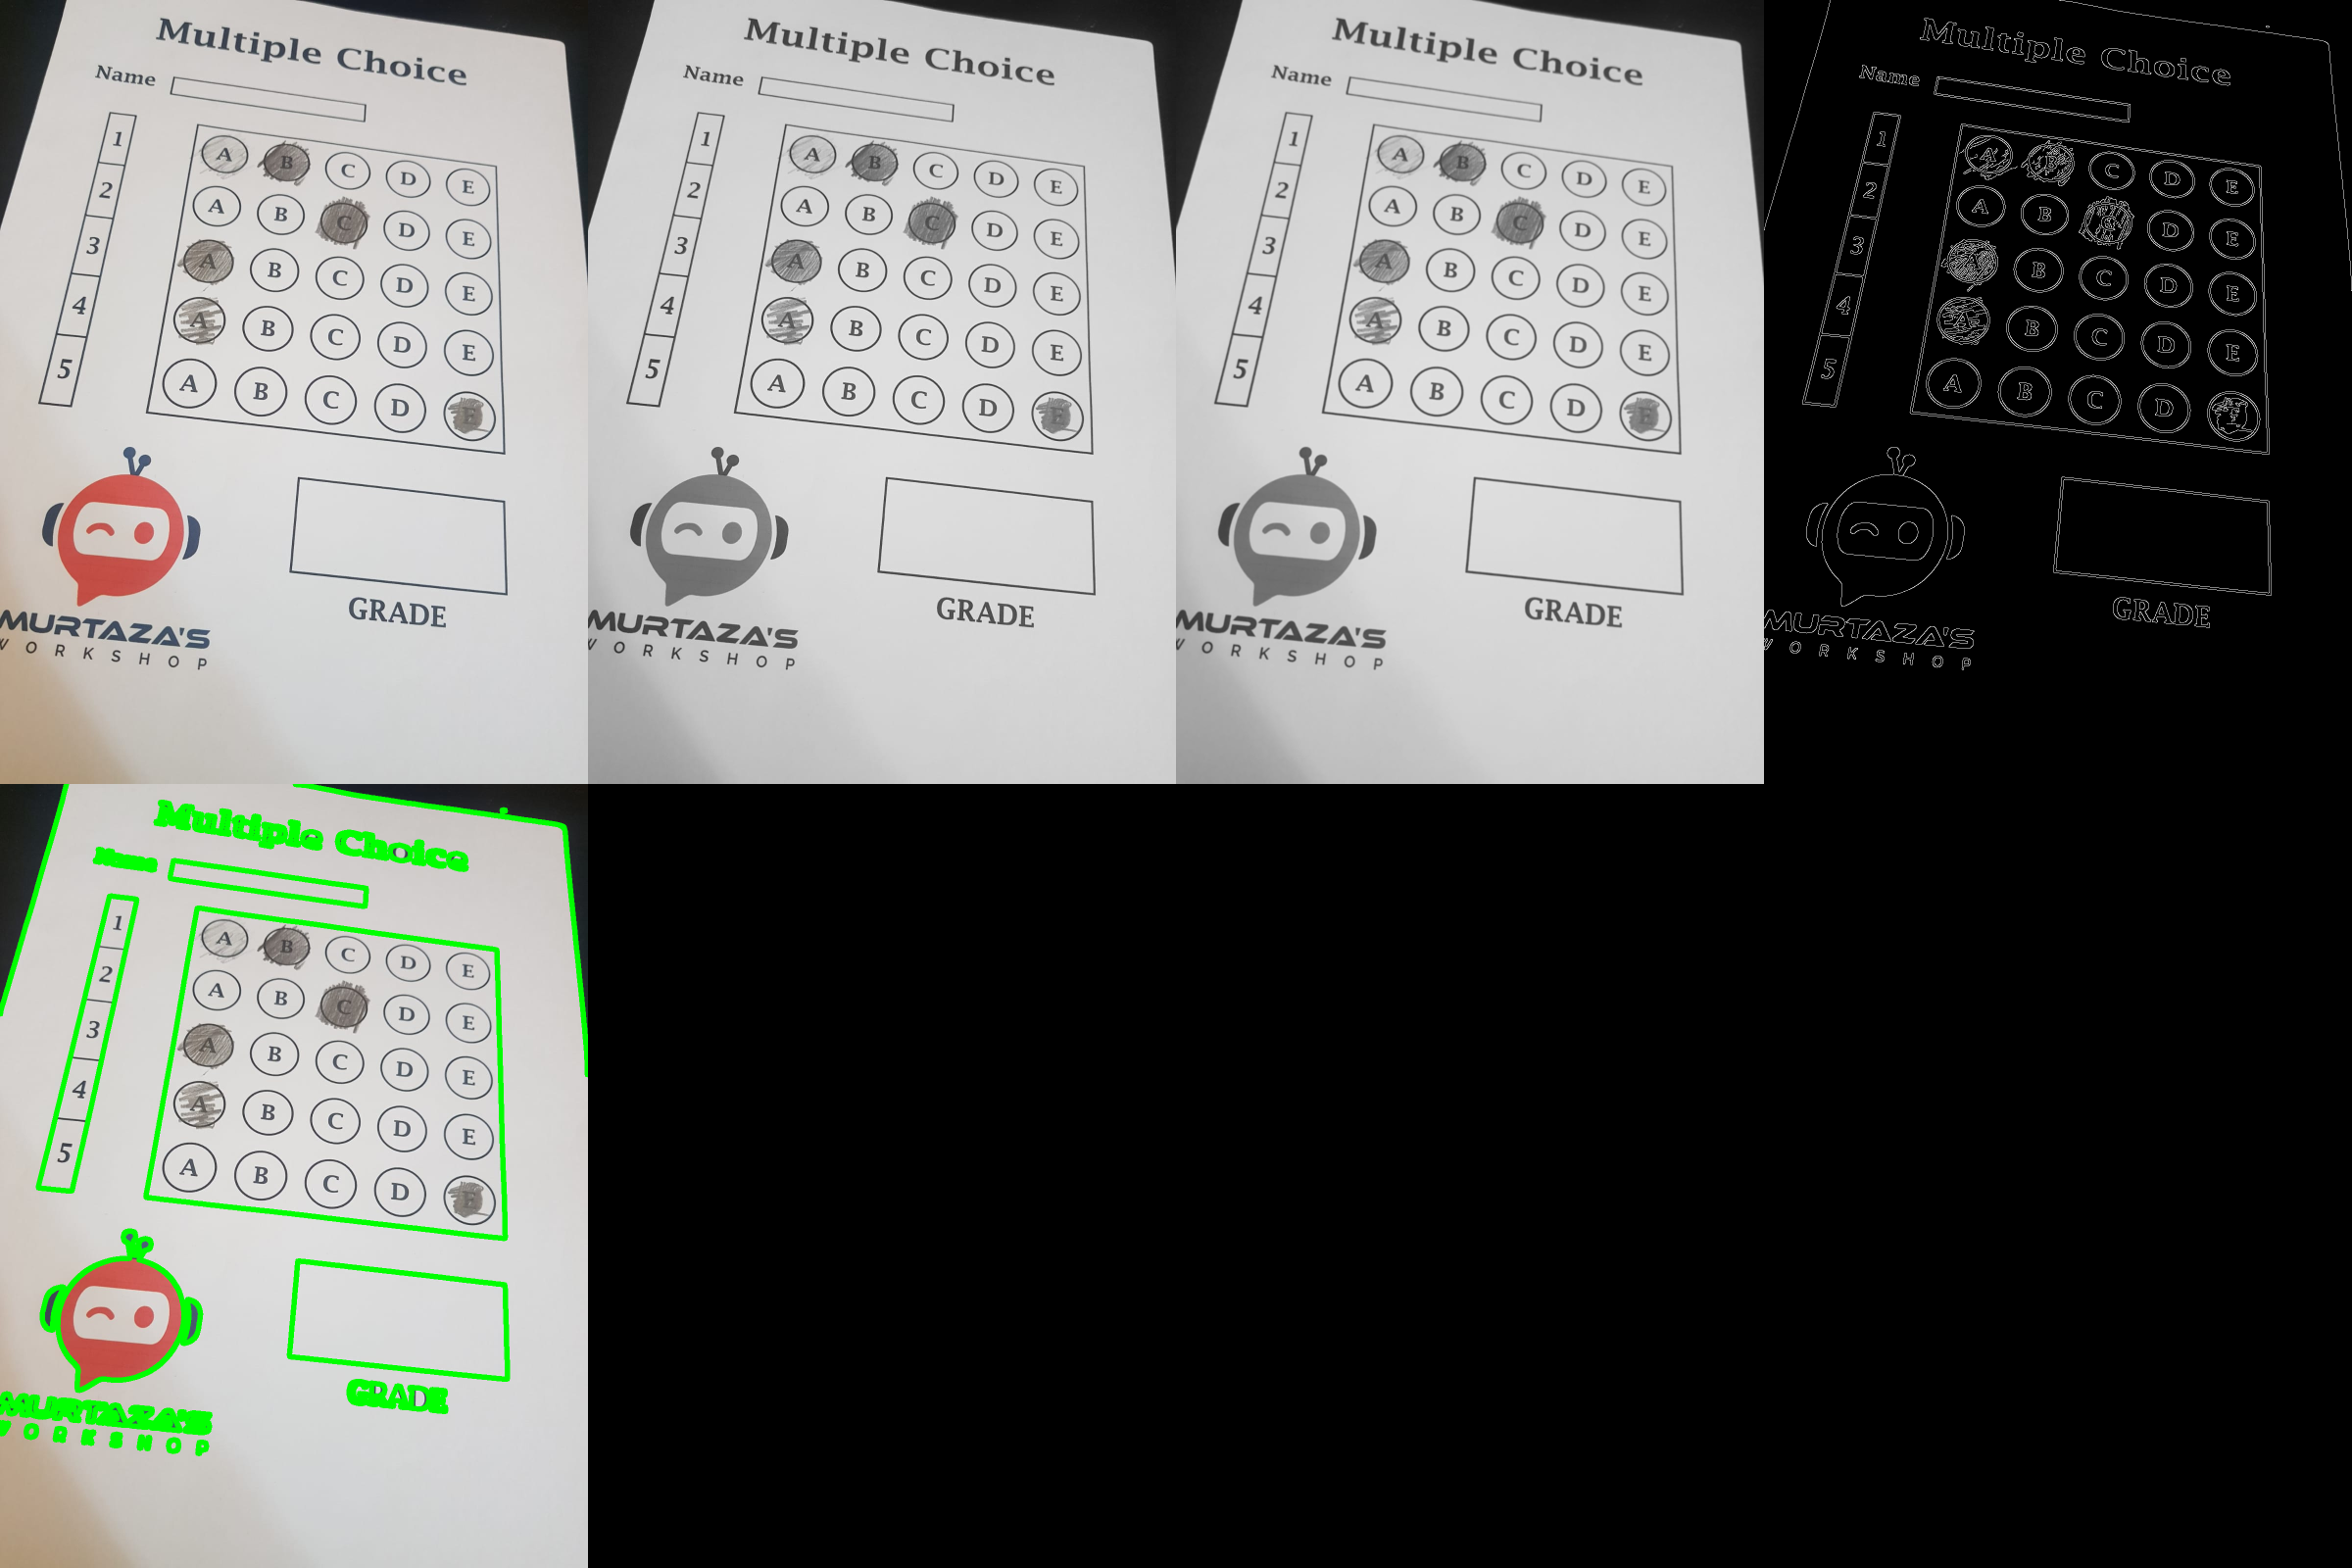

-1

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
## TO STACK ALL THE IMAGES IN ONE WINDOW
def stackImages(imgArray,scale,lables=[]):
    rows = len(imgArray)
    cols = len(imgArray[0])
    rowsAvailable = isinstance(imgArray[0], list)
    width = imgArray[0][0].shape[1]
    height = imgArray[0][0].shape[0]
    if rowsAvailable:
        for x in range ( 0, rows):
            for y in range(0, cols):
                imgArray[x][y] = cv2.resize(imgArray[x][y], (0, 0), None, scale, scale)
                if len(imgArray[x][y].shape) == 2: imgArray[x][y]= cv2.cvtColor( imgArray[x][y], cv2.COLOR_GRAY2BGR)
        imageBlank = np.zeros((height, width, 3), np.uint8)
        hor = [imageBlank]*rows
        hor_con = [imageBlank]*rows
        for x in range(0, rows):
            hor[x] = np.hstack(imgArray[x])
            hor_con[x] = np.concatenate(imgArray[x])
        ver = np.vstack(hor)
        ver_con = np.concatenate(hor)
    else:
        for x in range(0, rows):
            imgArray[x] = cv2.resize(imgArray[x], (0, 0), None, scale, scale)
            if len(imgArray[x].shape) == 2: imgArray[x] = cv2.cvtColor(imgArray[x], cv2.COLOR_GRAY2BGR)
        hor= np.hstack(imgArray)
        hor_con= np.concatenate(imgArray)
        ver = hor
    if len(lables) != 0:
        eachImgWidth= int(ver.shape[1] / cols)
        eachImgHeight = int(ver.shape[0] / rows)
        #print(eachImgHeight)
        for d in range(0, rows):
            for c in range (0,cols):
                cv2.rectangle(ver,(c*eachImgWidth,eachImgHeight*d),(c*eachImgWidth+len(lables[d][c])*13+27,30+eachImgHeight*d),(255,255,255),cv2.FILLED)
                cv2.putText(ver,lables[d][c],(eachImgWidth*c+10,eachImgHeight*d+20),cv2.FONT_HERSHEY_COMPLEX,0.7,(255,0,255),2)
    return ver

def reorder(myPoints):

    myPoints = myPoints.reshape((4, 2)) # REMOVE EXTRA BRACKET
    print(myPoints)
    myPointsNew = np.zeros((4, 1, 2), np.int32) # NEW MATRIX WITH ARRANGED POINTS
    add = myPoints.sum(1)
    print(add)
    print(np.argmax(add))
    myPointsNew[0] = myPoints[np.argmin(add)]  #[0,0]
    myPointsNew[3] =myPoints[np.argmax(add)]   #[w,h]
    diff = np.diff(myPoints, axis=1)
    myPointsNew[1] =myPoints[np.argmin(diff)]  #[w,0]
    myPointsNew[2] = myPoints[np.argmax(diff)] #[h,0]

    return myPointsNew

def rectContour(contours):

    rectCon = []
    max_area = 0
    for i in contours:
        area = cv2.contourArea(i)
        if area > 50:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i, 0.02 * peri, True)
            if len(approx) == 4:
                rectCon.append(i)
    rectCon = sorted(rectCon, key=cv2.contourArea,reverse=True)
    #print(len(rectCon))
    return rectCon

def getCornerPoints(cont):
    peri = cv2.arcLength(cont, True) # LENGTH OF CONTOUR
    approx = cv2.approxPolyDP(cont, 0.02 * peri, True) # APPROXIMATE THE POLY TO GET CORNER POINTS
    return approx

def splitBoxes(img):
    rows = np.vsplit(img,5)
    boxes=[]
    for r in rows:
        cols= np.hsplit(r,5)
        for box in cols:
            boxes.append(box)
    return boxes

def drawGrid(img,questions=5,choices=5):
    secW = int(img.shape[1]/questions)
    secH = int(img.shape[0]/choices)
    for i in range (0,9):
        pt1 = (0,secH*i)
        pt2 = (img.shape[1],secH*i)
        pt3 = (secW * i, 0)
        pt4 = (secW*i,img.shape[0])
        cv2.line(img, pt1, pt2, (255, 255, 0),2)
        cv2.line(img, pt3, pt4, (255, 255, 0),2)

    return img

def showAnswers(img,myIndex,grading,ans,questions=5,choices=5):
     secW = int(img.shape[1]/questions)
     secH = int(img.shape[0]/choices)

     for x in range(0,questions):
         myAns= myIndex[x]
         cX = (myAns * secW) + secW // 2
         cY = (x * secH) + secH // 2
         if grading[x]==1:
            myColor = (0,255,0)
            #cv2.rectangle(img,(myAns*secW,x*secH),((myAns*secW)+secW,(x*secH)+secH),myColor,cv2.FILLED)
            cv2.circle(img,(cX,cY),50,myColor,cv2.FILLED)
         else:
            myColor = (0,0,255)
            #cv2.rectangle(img, (myAns * secW, x * secH), ((myAns * secW) + secW, (x * secH) + secH), myColor, cv2.FILLED)
            cv2.circle(img, (cX, cY), 50, myColor, cv2.FILLED)

            # CORRECT ANSWER
            myColor = (0, 255, 0)
            correctAns = ans[x]
            cv2.circle(img,((correctAns * secW)+secW//2, (x * secH)+secH//2),
            20,myColor,cv2.FILLED)


# Load the image
image_path = '1.jpg'  # Change this to your uploaded image file name
img = cv2.imread(image_path)
imgcontour=img.copy()
# Convert to grayscale
imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur
imgBlur = cv2.GaussianBlur(imgGray, (5, 5), 1)

# Apply Canny edge detection
imgCanny = cv2.Canny(imgBlur, 10, 70)


# Find contours
contours, hierarchy = cv2.findContours(imgCanny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
cv2.drawContours(imgcontour,contours,-1,(0,255,0),10)

#image=drawGrid(img=img)
#cv2_imshow(image)
#cv2.waitKey(0)
imgblank=np.zeros_like(img)
imagearray=([img,imgGray,imgBlur,imgCanny],[imgcontour,imgblank,imgblank,imgblank])

imgstacked=stackImages(imagearray,0.5)
print("stacked images")
cv2_imshow(imgstacked)
cv2.waitKey(0)





[[234 110]
 [174 369]
 [601 405]
 [591 147]]
[ 344  543 1006  738]
2
[[354 426]
 [345 511]
 [604 530]
 [599 446]]
[ 780  856 1134 1045]
2


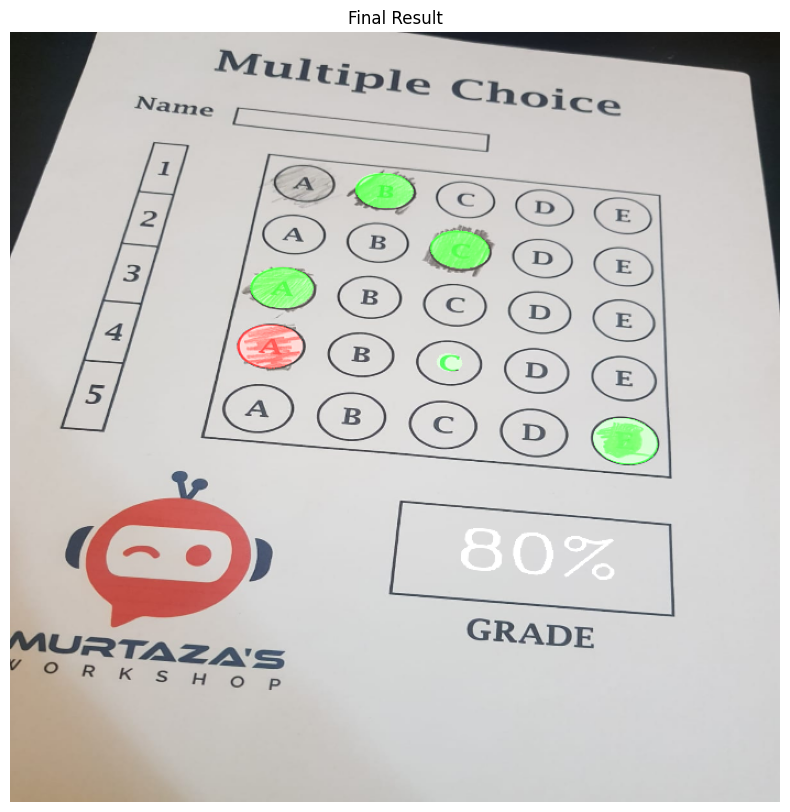

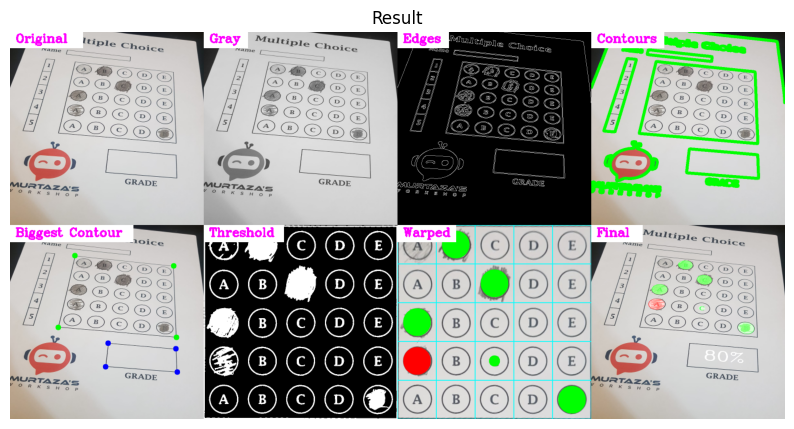

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

########################################################################
# Set this to False as we're not using a webcam in Google Colab
webCamFeed = False
pathImage = "1.jpg"  # Make sure the image is uploaded to Google Colab
heightImg = 700
widthImg = 700
questions = 5
choices = 5
ans = [1, 2, 0, 2, 4]
########################################################################

count = 0

if webCamFeed:
    cap = cv2.VideoCapture(1)
    cap.set(10, 160)
else:
    img = cv2.imread(pathImage)

# Function to display images in Google Colab
def display_image(img, title="Image"):
    plt.figure(figsize=(10, 10))
    if len(img.shape) == 2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

if not webCamFeed:
    img = cv2.resize(img, (widthImg, heightImg))  # Resize image
    imgFinal = img.copy()
    imgBlank = np.zeros((heightImg, widthImg, 3), np.uint8)  # Create a blank image for testing
    imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert image to gray scale
    imgBlur = cv2.GaussianBlur(imgGray, (5, 5), 1)  # Add Gaussian blur
    imgCanny = cv2.Canny(imgBlur, 10, 70)  # Apply Canny

    try:
        # Find all contours
        imgContours = img.copy()  # Copy image for display purposes
        imgBigContour = img.copy()  # Copy image for display purposes
        contours, hierarchy = cv2.findContours(imgCanny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)  # Find all contours
        cv2.drawContours(imgContours, contours, -1, (0, 255, 0), 10)  # Draw all detected contours
        rectCon = rectContour(contours)  # Filter for rectangle contours
        biggestPoints = getCornerPoints(rectCon[0])  # Get corner points of the biggest rectangle
        gradePoints = getCornerPoints(rectCon[1])  # Get corner points of the second biggest rectangle

        if biggestPoints.size != 0 and gradePoints.size != 0:
            # Biggest rectangle warping
            biggestPoints = reorder(biggestPoints)  # Reorder for warping
            cv2.drawContours(imgBigContour, biggestPoints, -1, (0, 255, 0), 20)  # Draw the biggest contour
            pts1 = np.float32(biggestPoints)  # Prepare points for warp
            pts2 = np.float32([[0, 0], [widthImg, 0], [0, heightImg], [widthImg, heightImg]])  # Prepare points for warp
            matrix = cv2.getPerspectiveTransform(pts1, pts2)  # Get transformation matrix
            imgWarpColored = cv2.warpPerspective(img, matrix, (widthImg, heightImg))  # Apply warp perspective

            # Second biggest rectangle warping
            cv2.drawContours(imgBigContour, gradePoints, -1, (255, 0, 0), 20)  # Draw the biggest contour
            gradePoints = reorder(gradePoints)  # Reorder for warping
            ptsG1 = np.float32(gradePoints)  # Prepare points for warp
            ptsG2 = np.float32([[0, 0], [325, 0], [0, 150], [325, 150]])  # Prepare points for warp
            matrixG = cv2.getPerspectiveTransform(ptsG1, ptsG2)  # Get transformation matrix
            imgGradeDisplay = cv2.warpPerspective(img, matrixG, (325, 150))  # Apply warp perspective

            # Apply threshold
            imgWarpGray = cv2.cvtColor(imgWarpColored, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
            imgThresh = cv2.threshold(imgWarpGray, 170, 255, cv2.THRESH_BINARY_INV)[1]  # Apply threshold and inverse

            boxes = splitBoxes(imgThresh)  # Get individual boxes
           # display_image(boxes[3], "Split Test")
            countR = 0
            countC = 0
            myPixelVal = np.zeros((questions, choices))  # To store the non-zero values of each box
            for image in boxes:
                totalPixels = cv2.countNonZero(image)
                myPixelVal[countR][countC] = totalPixels
                countC += 1
                if countC == choices:
                    countC = 0
                    countR += 1

            # Find the user answers and put them in a list
            myIndex = []
            for x in range(questions):
                arr = myPixelVal[x]
                myIndexVal = np.where(arr == np.amax(arr))
                myIndex.append(myIndexVal[0][0])

            # Compare the values to find the correct answers
            grading = []
            for x in range(questions):
                if ans[x] == myIndex[x]:
                    grading.append(1)
                else:
                    grading.append(0)

            score = (sum(grading) / questions) * 100  # Final grade

            # Displaying answers
            showAnswers(imgWarpColored, myIndex, grading, ans)  # Draw detected answers
            drawGrid(imgWarpColored)  # Draw grid
            imgRawDrawings = np.zeros_like(imgWarpColored)  # New blank image with warp image size
            showAnswers(imgRawDrawings, myIndex, grading, ans)  # Draw on new image
            invMatrix = cv2.getPerspectiveTransform(pts2, pts1)  # Inverse transformation matrix
            imgInvWarp = cv2.warpPerspective(imgRawDrawings, invMatrix, (widthImg, heightImg))  # Inv image warp

            # Display grade
            imgRawGrade = np.zeros_like(imgGradeDisplay, np.uint8)  # New blank image with grade area size
            cv2.putText(imgRawGrade, str(int(score)) + "%", (70, 100),
                        cv2.FONT_HERSHEY_COMPLEX, 3, (50, 50, 50), 3)  # Add the grade to new image
            invMatrixG = cv2.getPerspectiveTransform(ptsG2, ptsG1)  # Inverse transformation matrix
            imgInvGradeDisplay = cv2.warpPerspective(imgRawGrade, invMatrixG, (widthImg, heightImg))  # Inv image warp

            # Show answers and grade on final image
            imgFinal = cv2.addWeighted(imgFinal, 1, imgInvWarp, 1, 0)
            imgFinal = cv2.addWeighted(imgFinal, 1, imgInvGradeDisplay, 1, 0)

            # Image array for display
            imageArray = ([img, imgGray, imgCanny, imgContours],
                          [imgBigContour, imgThresh, imgWarpColored, imgFinal])
            display_image(imgFinal, "Final Result")
    except Exception as e:
        print(f"An error occurred: {e}")
        imageArray = ([img, imgGray, imgCanny, imgContours],
                      [imgBlank, imgBlank, imgBlank, imgBlank])

    # Labels for display
    labels = [["Original", "Gray", "Edges", "Contours"],
              ["Biggest Contour", "Threshold", "Warped", "Final"]]

    stackedImage = stackImages(imageArray, 0.5, labels)
    display_image(stackedImage, "Result")
